# MedGAN

Model 3 | Subset ZINC15-III | Reinforcement Learning | 100k quinolines

In [1]:
# import packages

import numpy as np
import os
import pandas as pd
import datetime
import gc
import io
import json
import csv
import matplotlib.lines as mlines
import matplotlib.pyplot as plt
import networkx as nx
from rdkit.Chem import rdmolops
from rdkit.Chem.rdmolops import AddHs
from rdkit.Chem.rdmolops import GetMolFrags
from rdkit import Chem, RDLogger
from rdkit import DataStructs
from rdkit.Chem import AllChem, Draw, Descriptors
from rdkit.Chem import AtomValenceException
from rdkit.Chem import Descriptors
from rdkit.Chem import MolFromSmiles
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem import rdmolfiles
from rdkit.Chem.Draw import IPythonConsole, MolsToGridImage
from rdkit.Chem.Fingerprints import FingerprintMols
from rdkit.Chem.Scaffolds import MurckoScaffold
from rdkit.DataStructs.cDataStructs import TanimotoSimilarity
import rdkit.RDLogger as rdl
from tensorflow import keras
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.utils import plot_model
import tensorflow as tf
from keras import initializers
from keras.layers import BatchNormalization
from scipy.spatial.distance import pdist, squareform
import concurrent.futures
from tqdm import tqdm
import base64
from IPython.display import display
from IPython.display import Image
from multiprocessing import Pool, cpu_count
from PIL import Image
import gzip
import pickle
import psutil
import pygraphviz as pgv
import time
import shutil
RDLogger.DisableLog("rdApp.*")
tf.get_logger().setLevel('ERROR')
logger = rdl.logger()
logger.setLevel(rdl.ERROR)
logger.setLevel(rdl.CRITICAL)

2024-09-28 21:24:45.296977: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-28 21:24:45.958879: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Data Preprocessing: Filtering and Sampling of Quinoline Molecules

The following section is dedicated to loading and processing quinoline molecule data from the ZINC15 dataset. Initially, the script checks whether a pre-filtered dataset (non_duplicate_filtered_quinolines_zinc15_50atoms.csv) exists. If it doesn't, the original dataset (non_duplicate_quinolines_zinc15.csv) is loaded and molecules are filtered based on specific criteria:

Only molecules containing the atoms - Carbon (C), Nitrogen (N), Oxygen (O), Hydrogen (H), Fluorine (F), Sulfur (S), and Chlorine (Cl) are retained.
    
Molecules having up to a maximum of 50 atoms, including hydrogen, are considered.

Post filtering, duplicates are removed, and the processed data is saved for future use. If the filtered dataset already exists, it is directly loaded.

To ensure consistent results and manageable data sizes, a subsample of 100,000 molecules is randomly chosen from this dataset. This subsample is then saved for subsequent analyses. Lastly, as a quick verification, one molecule is printed to visualize its structure and compute its count of heavy atoms.

In [ ]:
# Load filtered csv or save a new one
csv_path = "../data/non_duplicate_filtered_quinolines_zinc15_50atoms.csv"
filtered_csv_path = "../data/non_duplicate_filtered_quinolines_zinc15_50atoms.csv"

allowed_atoms = {'C', 'N', 'O', 'H', 'F', 'S', 'Cl'}
max_atoms = 50

In [3]:
# Functions

def has_allowed_atoms(mol, allowed_atoms):
    for atom in mol.GetAtoms():
        if atom.GetSymbol() not in allowed_atoms:
            return False
    return True

def total_atoms(mol):
    return sum(atom.GetTotalNumHs() + 1 for atom in mol.GetAtoms())

def is_valid_smiles(smiles):
    molecule = Chem.MolFromSmiles(smiles)
    molecule = Chem.AddHs(molecule)
    if (molecule is not None
        and '*' not in smiles
        and has_allowed_atoms(molecule, allowed_atoms)
        and total_atoms(molecule) <= max_atoms):
        return smiles
    return None

def get_cpu_usage():
    return psutil.cpu_percent()

In [ ]:
# If filtered CSV doesn't exist, read the original CSV, apply the filter, and save the filtered data
if not os.path.isfile(filtered_csv_path):
    # Read CSV file
    data = pd.read_csv(csv_path, usecols=lambda col: col != 'index', header=None)

    valid_smiles = []
    for smiles in tqdm(data[0]):
        try:
            result = is_valid_smiles(smiles)
            if result is not None:
                valid_smiles.append(result)
        except Exception as e:
            print("Error processing item:", e)

    # Remove duplicates
    valid_smiles = list(set(valid_smiles))

    # Create DataFrame with valid SMILES
    data = pd.DataFrame(valid_smiles, columns=['smiles'])
    
    # Save the filtered data to a CSV file
    data.to_csv(filtered_csv_path, index=False)

# If filtered CSV exists, just load it
else:
    data = pd.read_csv(filtered_csv_path)

data = data.sample(n=100000, random_state=1, replace=False)
data.reset_index(drop=True, inplace=True)

# Save the subsample to a CSV file
data.to_csv("../data/non_duplicate_filtered_quinolines_zinc15_50atoms.csv", index=False)

SMILES: [H]Oc1c(C(=O)N([H])C([H])([H])C([H])(O[H])C([H])([H])C([H])(C([H])([H])[H])C([H])([H])[H])c([H])nc2c([H])c([H])c(C([H])([H])[H])c([H])c12
Num heavy atoms: 22


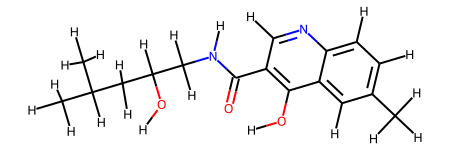

In [5]:
# print a sample from the dataset

smiles_test = data['smiles'][100]
print("SMILES:", smiles_test)
molecule = Chem.MolFromSmiles(smiles_test)
molecule = Chem.AddHs(molecule)
print("Num heavy atoms:", molecule.GetNumHeavyAtoms())
molecule

## Convert SMILEs to Graph representation

This code provides a suite of tools for representing molecules as graphs and vice versa. The main components are:

- Mappings: Dictionaries (atom_mapping, bond_mapping, charge_mapping) are used to translate atom and bond types between their string names and numerical indices.
Conversion Functions:

- smiles_to_graph(): Converts SMILES strings into graph matrices.

- graph_to_molecule(): Reconstructs molecules from their graph matrices.

- graph_to_networkx(): Transforms graph matrices into NetworkX graph objects for visualization or algorithmic analysis.

- Visualization: plot_graph() visually represents a molecule using the NetworkX graph, with atoms and bonds color-coded.

- Data Preprocessing: Molecular data is chunked and processed in parallel to convert batches of SMILES strings into graph representations, which are then saved as compressed files for efficiency.

If molecules are already converted to graphs and saved, will be loaded from compressed files.

Overall, these tools facilitate the transition between chemical molecular structures and their graph representations, offering a foundation for graph-based molecular analyses or neural networks.

In [ ]:
atom_mapping = {
    "C": 0,
    "N": 1,
    "O": 2,
    "H": 3,
    "F": 4,
    "S": 5,
    "Cl": 6,
}

bond_mapping = {
    "SINGLE": 0,
    0: Chem.BondType.SINGLE,
    "DOUBLE": 1,
    1: Chem.BondType.DOUBLE,
    "TRIPLE": 2,
    2: Chem.BondType.TRIPLE,
    "AROMATIC": 3,
    3: Chem.BondType.AROMATIC,
}

charge_mapping = {
    -1: 7,
    1: 8,
}

NUM_ATOMS = 50
ATOM_DIM = 11  # 7 atom types + 2 for chirality and 2 for charge
BOND_DIM = 4 + 1
LATENT_DIM = 256

# Convert to bidirectional mapping for simplicity
atom_mapping.update({v: k for k, v in atom_mapping.items()})

def graph_to_molecule(graph):
    adjacency, features = graph
    molecule = Chem.RWMol()

    # Filter out 'padding' atoms and bonds
    keep_idx = np.where(
        (np.sum(features[:, :ATOM_DIM], axis=1) != 0)  # not a 'padding' atom
        & (np.sum(adjacency[:-1], axis=(0, 1)) != 0)  # connected to something
    )[0]
    
    features = features[keep_idx]
    adjacency = adjacency[:, keep_idx, :][:, :, keep_idx]

    num_neighbors = np.sum(adjacency, axis=(0, 2))

    for i in range(len(keep_idx)):
        atom_type_idx = np.argmax(features[i, 0:7])
        atom_type = atom_mapping[atom_type_idx]
        atom = Chem.Atom(atom_type)

        # Handle charge
        charge_features = features[i, 7:9]  
        atom_charge = None
        for charge_value, charge_idx in charge_mapping.items():
            if charge_features[charge_idx - 7] == 1.0:  # Adjusting index for subset
                atom_charge = charge_value
                break

        if atom_charge is not None:
            atom.SetFormalCharge(atom_charge)

        # Handle chirality with neighbor check
        if num_neighbors[i] >= 3:  # only consider atoms with at least 3 neighbors
            if features[i, 9] == 1:
                atom.SetChiralTag(Chem.ChiralType.CHI_TETRAHEDRAL_CCW)
            elif features[i, 10] == 1:
                atom.SetChiralTag(Chem.ChiralType.CHI_TETRAHEDRAL_CW)

        _ = molecule.AddAtom(atom)

    (bonds_ij, atoms_i, atoms_j) = np.where(np.triu(adjacency) == 1)
    for (bond_ij, atom_i, atom_j) in zip(bonds_ij, atoms_i, atoms_j):
        if atom_i == atom_j or bond_ij == BOND_DIM - 1:
            continue
        bond_type = bond_mapping[bond_ij]
        molecule.AddBond(int(atom_i), int(atom_j), bond_type)

    # Sanitize the molecule
    try:
        # Attempt to sanitize the molecule
        flag = Chem.SanitizeMol(molecule, catchErrors=True)
        
        # Check the flag returned by the sanitization
        if flag != Chem.SanitizeFlags.SANITIZE_NONE:
            return None  

    except AtomValenceException as e:
        print(f"AtomValenceException during molecule sanitization: {e}")
        return None
    except ValueError as e:
        if "Violation occurred" in str(e) and "MolFileStereochem.cpp" in str(e):
            print(f"Chirality error during molecule sanitization: {e}")
            return None
    except Exception as e:
        print(f"Unexpected error during molecule sanitization: {e}")
        return None

    return molecule


This code sample is set for a subsample of 100,000 graphs already converted from molecules.

In [ ]:
save_folder = "../data/data_zinc15_subset-iii/"
chunk_size = 100000

num_chunks = len(data) // chunk_size
#print(num_chunks)

def process_chunk(i):
    adjacency_tensor_file = os.path.join(save_folder, f'adjacency_tensor_{i}.npz')
    feature_tensor_file = os.path.join(save_folder, f'feature_tensor_{i}.npz')

    # If tensors exist, load them (decompressed)
    adjacency_tensor = np.load(adjacency_tensor_file)['arr_0']
    feature_tensor = np.load(feature_tensor_file)['arr_0']
    
    print(f"Loaded tensors from chunk {i}")

    return adjacency_tensor, feature_tensor

adjacency_tensors = []
feature_tensors = []

# Process each chunk individually after loading
for i in tqdm(range(num_chunks), desc='Loading data chunks'):
    adjacency_tensor, feature_tensor = process_chunk(i)
    adjacency_tensors.append(adjacency_tensor)
    feature_tensors.append(feature_tensor)

adjacency_tensor = np.concatenate(adjacency_tensors)
feature_tensor = np.concatenate(feature_tensors)

print("adjacency_tensor.shape =", adjacency_tensor.shape)
print("feature_tensor.shape =", feature_tensor.shape)

## WGAN R-GCN implementation

This code provides a detailed walkthrough of the implementation of WGAN R-GCN using the Keras library. We break down the components into two main sections: the Graph Generator and the Graph Discriminator.

The Graph Generator function, GraphGenerator, is responsible for creating a graph representation of a molecule given latent space inputs.

The Graph Discriminator function, GraphDiscriminator, assesses the "realness" of a molecule graph. It uses graph convolution layers to process the adjacency and feature matrices, and provides a scalar output representing the authenticity of the input graph.

2024-09-28 21:26:42.472832: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355


Model: "Generator"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256)]        0           []                               
                                                                                                  
 dense (Dense)                  (None, 128)          32896       ['input_1[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 128)          0           ['dense[0][0]']                  
                                                                                                  
 dense_1 (Dense)                (None, 256)          33024       ['dropout[0][0]']                
                                                                                          

2024-09-28 21:26:42.501925: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-09-28 21:26:42.503927: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-09-28 21:26:42.507527: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

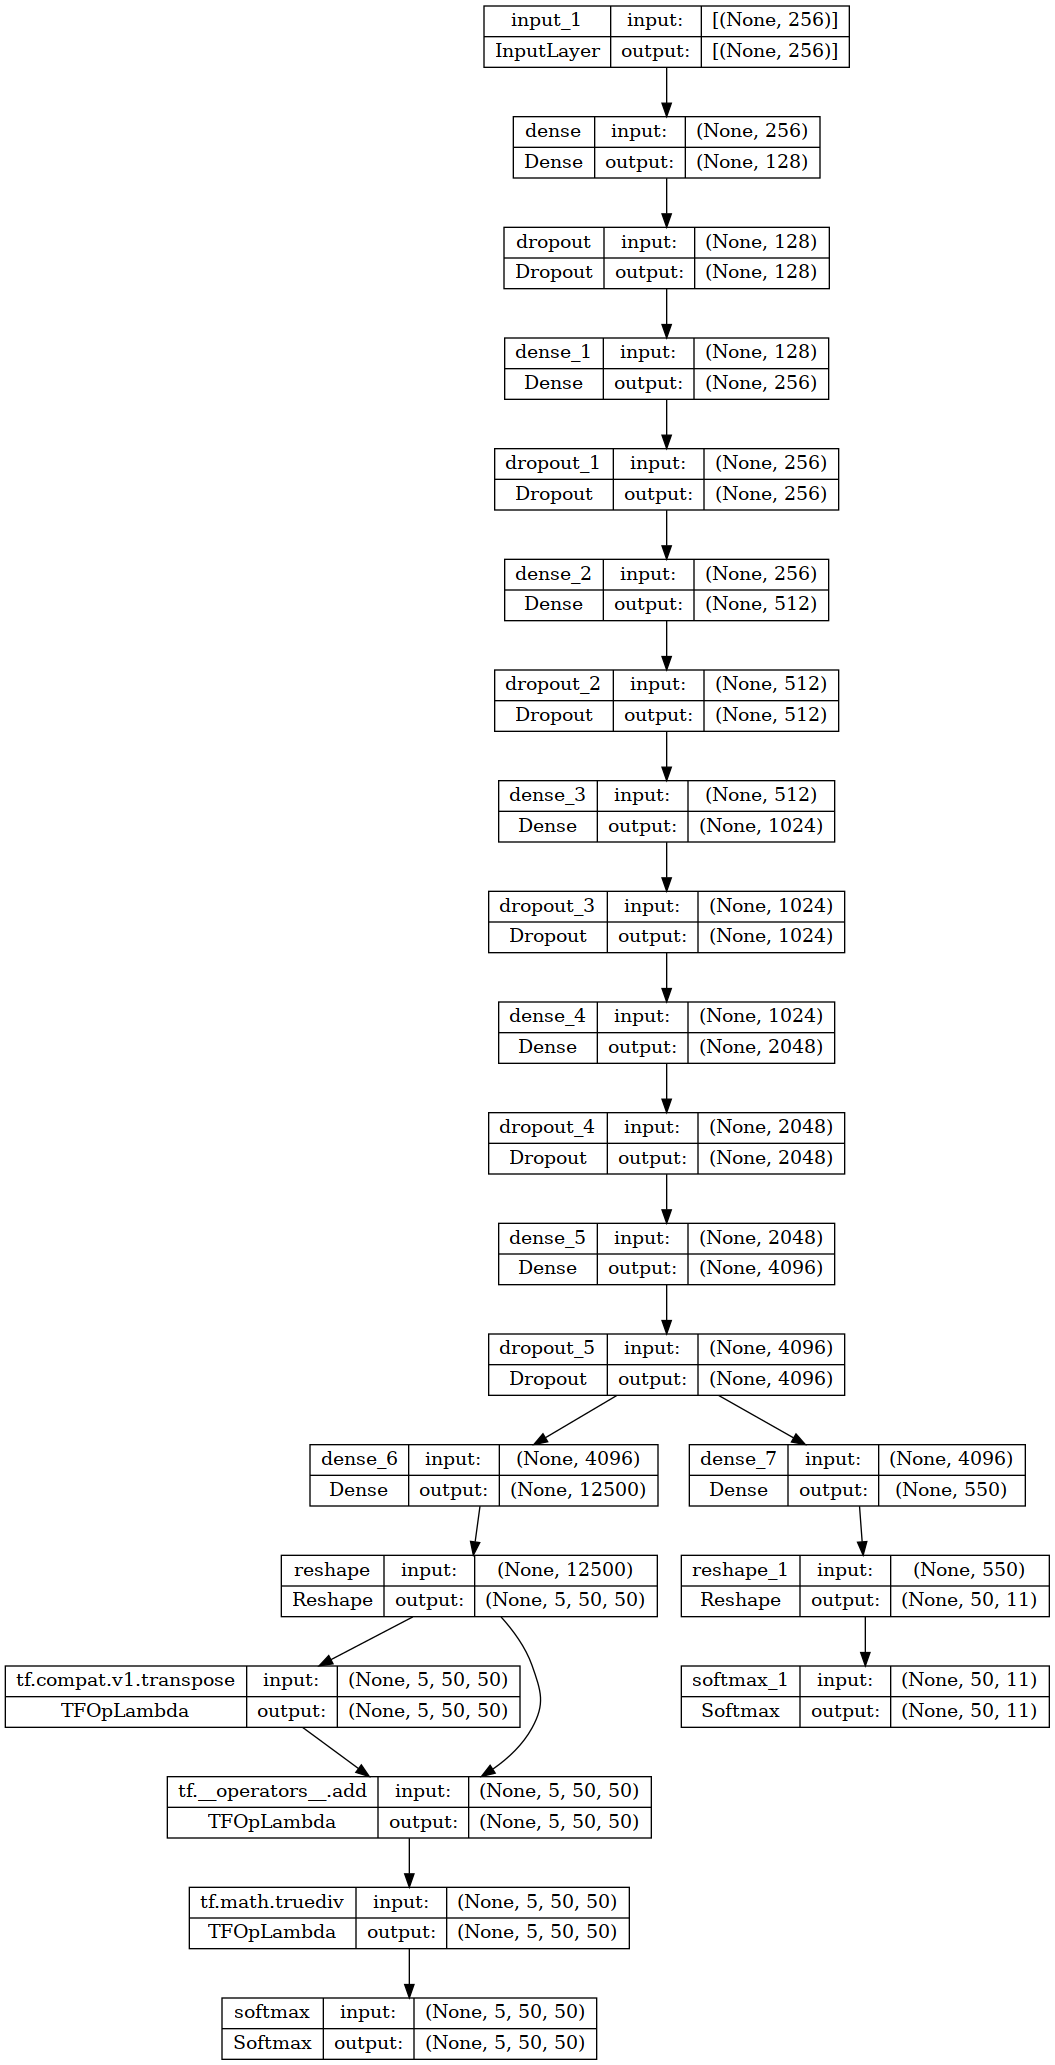

In [8]:
def GraphGenerator(
    dense_units, dropout_rate, latent_dim, adjacency_shape, feature_shape, l1_value=0.1
):
    
    # placeholder for the AutoEncoder
    
    z = keras.layers.Input(shape=(LATENT_DIM,))
    # Propagate through one or more densely connected layers
    x = z
    for units in dense_units:
        #x = keras.layers.BatchNormalization()(x) #    
        x = keras.layers.Dense(units, activation="tanh")(x) #, kernel_regularizer=regularizers.l1(l1_value)
        x = keras.layers.Dropout(dropout_rate)(x)

    # Map outputs of previous layer (x) to [continuous] adjacency tensors (x_adjacency)
    x_adjacency = keras.layers.Dense(tf.math.reduce_prod(adjacency_shape))(x)
    x_adjacency = keras.layers.Reshape(adjacency_shape)(x_adjacency)
    # Symmetrify tensors in the last two dimensions
    x_adjacency = (x_adjacency + tf.transpose(x_adjacency, (0, 1, 3, 2))) / 2
    x_adjacency = keras.layers.Softmax(axis=1)(x_adjacency)

    # Map outputs of previous layer (x) to [continuous] feature tensors (x_features)
    x_features = keras.layers.Dense(tf.math.reduce_prod(feature_shape))(x)
    x_features = keras.layers.Reshape(feature_shape)(x_features)
    x_features = keras.layers.Softmax(axis=2)(x_features)

    return keras.Model(inputs=z, outputs=[x_adjacency, x_features], name="Generator")

generator = GraphGenerator(
    dense_units=[128, 256, 512, 1024, 2048, 4096],
    dropout_rate=0.10,
    latent_dim=LATENT_DIM,
    adjacency_shape=(BOND_DIM, NUM_ATOMS, NUM_ATOMS),
    feature_shape=(NUM_ATOMS, ATOM_DIM),
)
generator.summary()

# Save the model summary to a text file
with open('generator_summary_model3_zinc15_iii.txt', 'w') as f:
    generator.summary(print_fn=lambda x: f.write(x + '\n'))

# Save the model structure as an image
plot_model(generator, to_file='generator_model3_zinc15_iii.png', show_shapes=True, show_layer_names=True)

Model: "Discriminator"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 5, 50, 50)]  0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 50, 11)]     0           []                               
                                                                                                  
 relational_graph_conv_layer (R  (None, 50, 512)     28160       ['input_2[0][0]',                
 elationalGraphConvLayer)                                         'input_3[0][0]']                
                                                                                                  
 relational_graph_conv_layer_1   (None, 50, 512)     1310720     ['input_2[0][0]',    

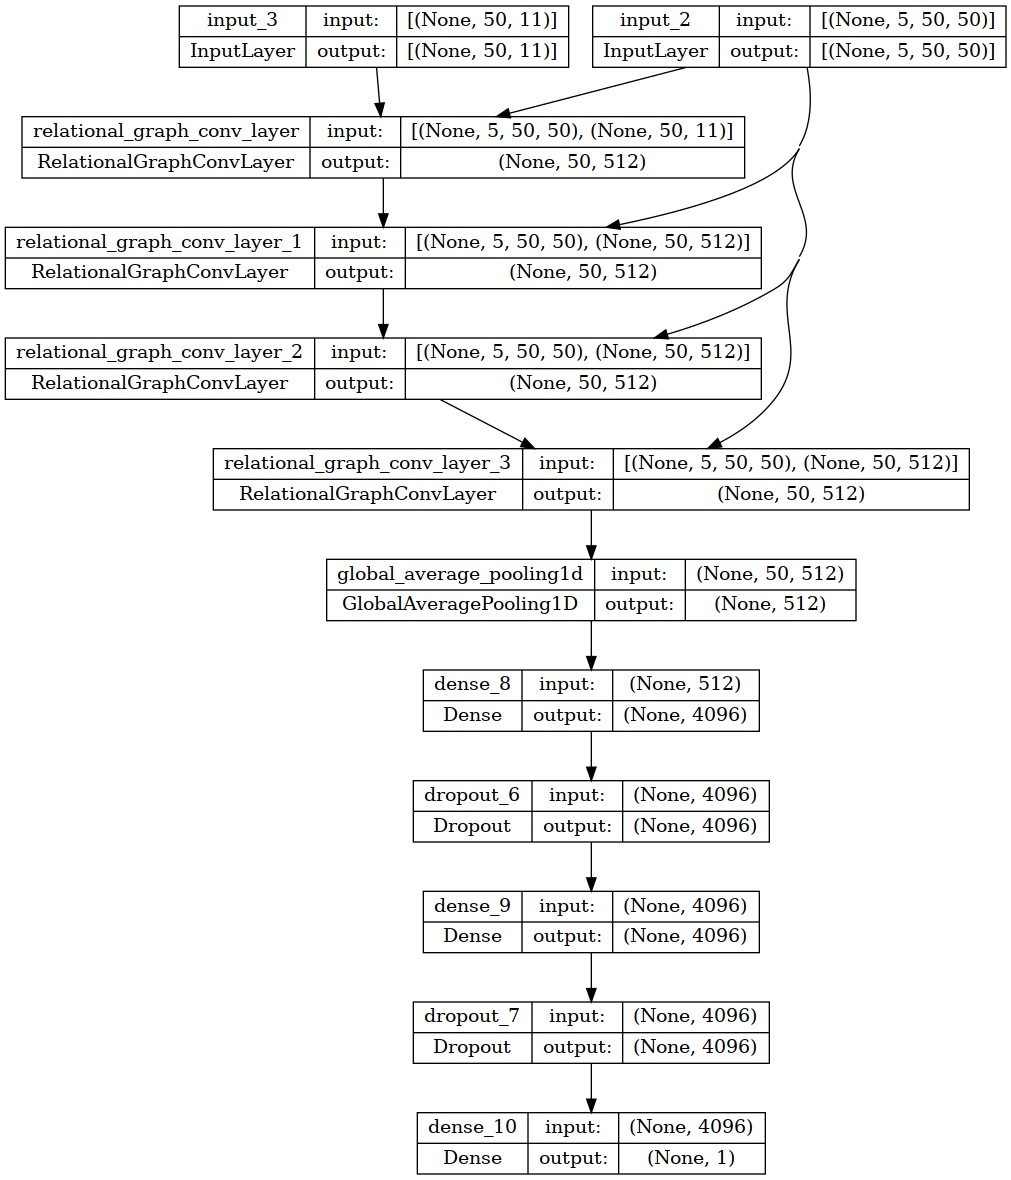

In [9]:
class RelationalGraphConvLayer(keras.layers.Layer):
    def __init__(
        self,
        units=128,  # 128
        activation="relu",
        use_bias=False,
        kernel_initializer="glorot_uniform",    
        bias_initializer="zeros",
        kernel_regularizer=None,
        #kernel_regularizer=regularizers.l1(0.01),    #None,
        bias_regularizer=None,
        **kwargs
    ):
        super().__init__(**kwargs)

        self.units = units
        self.activation = keras.activations.get(activation)
        self.use_bias = use_bias
        self.kernel_initializer = keras.initializers.get(kernel_initializer)
        self.bias_initializer = keras.initializers.get(bias_initializer)
        self.kernel_regularizer = keras.regularizers.get(kernel_regularizer)
        self.bias_regularizer = keras.regularizers.get(bias_regularizer)

    def build(self, input_shape):
        bond_dim = input_shape[0][1]
        atom_dim = input_shape[1][2]

        self.kernel = self.add_weight(
            shape=(bond_dim, atom_dim, self.units),
            initializer=self.kernel_initializer,
            regularizer=self.kernel_regularizer,
            trainable=True,
            name="W",
            dtype=tf.float32,
        )

        if self.use_bias:
            self.bias = self.add_weight(
                shape=(bond_dim, 1, self.units),
                initializer=self.bias_initializer,
                regularizer=self.bias_regularizer,
                trainable=True,
                name="b",
                dtype=tf.float32,
            )

        self.built = True

    def call(self, inputs, training=False):
        adjacency, features = inputs
        # Aggregate information from neighbors
        x = tf.matmul(adjacency, features[:, None, :, :])
        # Apply linear transformation
        x = tf.matmul(x, self.kernel)
        if self.use_bias:
            x += self.bias
        # Reduce bond types dim
        x_reduced = tf.reduce_sum(x, axis=1)
        # Apply non-linear transformation
        return self.activation(x_reduced)


def GraphDiscriminator(
    gconv_units, dense_units, dropout_rate, adjacency_shape, feature_shape, l1_value=0.01
):

    adjacency = keras.layers.Input(shape=adjacency_shape)
    features = keras.layers.Input(shape=feature_shape)

    # Propagate through one or more graph convolutional layers
    features_transformed = features
    for units in gconv_units:
        features_transformed = RelationalGraphConvLayer(units)(
            [adjacency, features_transformed]
        )

    # Reduce 2-D representation of molecule to 1-D
    x = keras.layers.GlobalAveragePooling1D()(features_transformed)

    # Propagate through one or more densely connected layers
    for units in dense_units:
        #x = keras.layers.Dense(units, activation="relu")(x)
        x = keras.layers.Dense(units, activation="relu")(x) #, kernel_regularizer=regularizers.l1(l1_value)
        x = keras.layers.Dropout(dropout_rate)(x)

    # For each molecule, output a single scalar value expressing the "realness" of the inputted molecule
    x_out = keras.layers.Dense(1, dtype="float32")(x)

    return keras.Model(inputs=[adjacency, features], outputs=x_out, name='Discriminator')

discriminator = GraphDiscriminator(
    gconv_units= [512, 512, 512, 512], 
    dense_units= [4096, 4096],
    dropout_rate=0.10,
    adjacency_shape=(BOND_DIM, NUM_ATOMS, NUM_ATOMS),
    feature_shape=(NUM_ATOMS, ATOM_DIM),
)
discriminator.summary()

# Save the model summary to a text file
with open('discriminator_summary_model3_zinc15_iii.txt', 'w') as f:
    discriminator.summary(print_fn=lambda x: f.write(x + '\n'))

# Save the model structure as an image
plot_model(discriminator, to_file='discriminator_model3_zinc15_iii.png', show_shapes=True, show_layer_names=True)

## Generative Adversarial Network for Graphs

The GraphWGAN class implements a Generative Adversarial Network (GAN) to generate graphs. This GAN leverages Wasserstein distance with gradient penalty for training stability.

The train_step method trains the GAN for one step. This involves training the discriminator to differentiate between real and generated graphs, and training the generator to produce graphs that the discriminator cannot differentiate from real graphs.

In [ ]:
class GraphWGAN(keras.Model):
    def __init__(
        self,
        generator,
        discriminator,
        discriminator_steps=1,
        generator_steps=1,
        gp_weight=10,
        **kwargs
    ):
        super().__init__(**kwargs)
        self.generator = generator
        self.discriminator = discriminator
        self.discriminator_steps = discriminator_steps
        self.generator_steps = generator_steps
        self.gp_weight = gp_weight
        self.latent_dim = self.generator.input_shape[-1]
        self.epoch = 0
        self.batch = 0
        self.quinoline_scaffold = Chem.MolFromSmiles("n1cccc2ccccc12")

        # We will store our dynamic "reward" scalars here
        self.value_for_zeros = 1.0
        self.value_for_ones = 10.0  # Start at 10 and we will adaptively increase it.

        # Initialize metrics for the logs
        self.metric_loss_gp = keras.metrics.Mean(name='loss_gp')
        self.metric_discriminator_loss = keras.metrics.Mean(name='discriminator_loss')
        self.metric_disc_loss = keras.metrics.Mean(name='disc_loss')
        self.metric_rewards = keras.metrics.Mean(name='rewards')
        self.metric_connectivity_g = keras.metrics.Mean(name='connectivity_g')
        self.metric_gen_loss = keras.metrics.Mean(name='gen_loss')
        self.metric_critic_g_fake = keras.metrics.Mean(name='critic_g_fake')
        self.metric_critic_g_fake_loss = keras.metrics.Mean(name='critic_g_fake_loss')

    def compile(self, optimizer_generator, optimizer_discriminator, **kwargs):
        super().compile(**kwargs)
        self.optimizer_generator = optimizer_generator
        self.optimizer_discriminator = optimizer_discriminator

    # code to generate samples and rewards
    def z_to_mol(self, graph, sample_size):
        adjacency = tf.argmax(graph[0], axis=1)
        adjacency = tf.one_hot(adjacency, depth=BOND_DIM, axis=1)
        adjacency = tf.linalg.set_diag(adjacency, tf.zeros(tf.shape(adjacency)[:-1]))
        features = tf.argmax(graph[1], axis=2)
        features = tf.one_hot(features, depth=ATOM_DIM, axis=2)
        molecules = []
        for i in range(sample_size):    # for i in range(sample_size):
            try:
                mol = graph_to_molecule([adjacency[i].numpy(), features[i].numpy()])
                if mol:
                    molecules.append(mol)
                else:
                    molecules.append(None)
            except AtomValenceException as e:
                logging.error(f"AtomValenceException during molecule generation: {e}")
                molecules.append(None)
            except ValueError as e:
                if "Violation occurred" in str(e) and "MolFileStereochem.cpp" in str(e):
                    logging.error(f"Chirality error during molecule generation: {e}")
                    molecules.append(None)
                else:
                    logging.error(f"Unexpected ValueError during molecule generation: {e}")
                    molecules.append(None)
            except RuntimeError as e:
                logging.error(f"RuntimeError during molecule generation: {e}")
                molecules.append(None)
            except Exception as e:
                logging.error(f"Unexpected error during molecule generation: {e}")
                molecules.append(None)
        return molecules

    # code to train
    def train_step(self, inputs):
        start_time = time.time()
        noise_dim = self.generator.input_shape[1]

        if isinstance(inputs[0], tuple):
            inputs = inputs[0]

        real_graphs = inputs
        self.batch_size = tf.shape(inputs[0])[0]

        def individual_metric_validity(molecule):
            if molecule is None or molecule.GetNumAtoms() == 0:
                return 0
            try:
                mol_block = Chem.MolToMolBlock(molecule)
                if not all(char == '0' for char in mol_block):
                    num_frags = len(rdmolops.GetMolFrags(molecule, asMols=False, sanitizeFrags=False))
                    if num_frags == 1:
                        return 1
                    else:
                        return 0
            except Exception:
                return 0

        # Training the discriminator (critic)
        for _ in range(self.discriminator_steps):
            
            with tf.GradientTape() as disc_tape:

                z = tf.random.normal([self.batch_size, self.latent_dim])
                generated_d_graphs = self.generator(z, training=True)

                critic_real = self.discriminator(real_graphs, training=True)
                critic_fake = self.discriminator(generated_d_graphs, training=True)

                # Calculate gradient penalty
                loss_gp = self._gradient_penalty(real_graphs, generated_d_graphs)
                discriminator_loss = tf.reduce_mean(critic_fake) - tf.reduce_mean(critic_real)
                disc_loss = discriminator_loss + loss_gp * self.gp_weight

            gradients_of_discriminator = disc_tape.gradient(disc_loss, self.discriminator.trainable_variables)
            self.optimizer_discriminator.apply_gradients(zip(gradients_of_discriminator, self.discriminator.trainable_variables))

            # Update the metric values
            self.metric_loss_gp.update_state(loss_gp)    
            self.metric_discriminator_loss.update_state(discriminator_loss)    
            self.metric_disc_loss.update_state(disc_loss)    

        # Training the generator
        for _ in range(self.generator_steps):
            with tf.GradientTape() as gen_tape:
                # Generate fake data here
                z = tf.random.normal([self.batch_size, self.latent_dim])
                generated_g_graphs = self.generator(z, training=True)

                # Convert generated graphs to molecules for reward calculation
                generated_g_molecules = self.z_to_mol(graph=generated_g_graphs, sample_size=self.batch_size)
                
                critic_g_fake = self.discriminator(generated_g_graphs, training=True)
                critic_g_fake_tensor = tf.convert_to_tensor(critic_g_fake, dtype=tf.float32)
                critic_g_fake_loss = -tf.reduce_mean(critic_g_fake)

                # Calculate rewards based on molecule connectivity
                rewards = [individual_metric_validity(mol) for mol in generated_g_molecules]
                rewards_tensor = tf.convert_to_tensor(rewards, dtype=tf.float32)

                connectivity_g_numpy = np.array(rewards)
                connectivity_g = np.mean(connectivity_g_numpy)

                # We use our dynamic "value_for_zeros" and "value_for_ones"
                scaled_rewards_tensor = tf.where(
                    rewards_tensor == 0, 
                    self.value_for_zeros,   # e.g. 1.0
                    self.value_for_ones    # e.g. 10.0, adaptively updated
                )

                # Reshape scaled rewards for element-wise multiplication with critic scores
                adjusted_critic_scores = critic_g_fake_tensor * tf.reshape(scaled_rewards_tensor, (-1, 1))
                adjusted_critic_scores_loss = -tf.reduce_mean(adjusted_critic_scores)

                lambda_reward = 1.0

                # Calculate the generator loss
                gen_loss = lambda_reward * adjusted_critic_scores_loss   # -tf.reduce_mean(adjusted_critic_scores)
        
                # Apply generator gradients
                gradients_of_generator = gen_tape.gradient(gen_loss, self.generator.trainable_variables)

                # Apply the clipped gradients
                self.optimizer_generator.apply_gradients(zip(gradients_of_generator, self.generator.trainable_variables))

            # Update the metric values
            self.metric_rewards.update_state(rewards)
            self.metric_connectivity_g.update_state(connectivity_g)
            self.metric_gen_loss.update_state(gen_loss)
            self.metric_critic_g_fake.update_state(critic_g_fake)
            self.metric_critic_g_fake_loss.update_state(critic_g_fake_loss)

        # Increment the epoch counter
        self.epoch += 1
    
        end_time = time.time()
        time_per_epoch = end_time - start_time

        logs = {m.name: m.result() for m in self.metrics}
        logs['time'] = time_per_epoch

        return logs

    def _gradient_penalty(self, graph_real, graph_generated):
        # Unpack graphs
        adjacency_real, features_real = graph_real
        adjacency_generated, features_generated = graph_generated

        # Generate interpolated graphs (adjacency_interp and features_interp)
        alpha = tf.random.uniform([self.batch_size])
        alpha = tf.reshape(alpha, (self.batch_size, 1, 1, 1))
        adjacency_interp = (adjacency_real * alpha) + (1 - alpha) * adjacency_generated
        alpha = tf.reshape(alpha, (self.batch_size, 1, 1))
        features_interp = (features_real * alpha) + (1 - alpha) * features_generated

        # Compute the logits of interpolated graphs
        with tf.GradientTape() as tape:
            tape.watch(adjacency_interp)
            tape.watch(features_interp)
            logits = self.discriminator(
                [adjacency_interp, features_interp], training=True
            )

        # Compute the gradients with respect to the interpolated graphs
        grads = tape.gradient(logits, [adjacency_interp, features_interp])
        # Compute the gradient penalty
        grads_adjacency_penalty = (1 - tf.norm(grads[0], axis=1)) ** 2
        grads_features_penalty = (1 - tf.norm(grads[1], axis=2)) ** 2
        return tf.reduce_mean(
            tf.reduce_mean(grads_adjacency_penalty, axis=(-2, -1))
            + tf.reduce_mean(grads_features_penalty, axis=(-1))
        )

    def save_model(self, folder_path="training_models_model3_zinc15_iii/WGAN"):
        if not os.path.exists(folder_path):
            os.makedirs(folder_path)
        self.generator.save(os.path.join(folder_path, "generator"))
        self.discriminator.save(os.path.join(folder_path, "discriminator"))

    def load_model(self, folder_path="training_models_model3_zinc15_iii/WGAN"):
        self.generator = keras.models.load_model(os.path.join(folder_path, "generator"))
        self.discriminator = keras.models.load_model(os.path.join(folder_path, "discriminator"))


## Training metrics

This code is a detailed implementation of logging various metrics on Tensorboard related to the progress and performance of a Generative Adversarial Network (GAN) designed to generate molecular structures. It computes metrics such as validity, uniqueness, novelty, quinoline, and scaffold similarity. But also training performance on weights and layers.

In [ ]:
# Load the full quinoline dataset
quinolines_df = pd.read_csv("../data/non_duplicate_filtered_quinolines_zinc15_50atoms.csv")
full_quinolines_smiles = set(quinolines_df['smiles'].tolist())

In [ ]:
class GANLogger(tf.keras.callbacks.Callback):
    def __init__(self, tensorboard_logdir, original_dataset, full_dataset, num_samples):
        super().__init__()
        self.tensorboard_logdir = tensorboard_logdir
        self.writer = tf.summary.create_file_writer(tensorboard_logdir)
        self.original_smiles = set(original_dataset)
        self.full_quinolines_smiles = set(full_dataset)
        self.num_samples = num_samples
        self.quinoline_scaffold = Chem.MolFromSmiles("n1cccc2ccccc12")
        self.best_connected_validity = 0.0
        self.epochs_without_improvement = 0

    def mol_sample(self, generator, batch_size):
        z = tf.random.normal((batch_size, LATENT_DIM))
        graph = generator.predict(z)
        adjacency = tf.argmax(graph[0], axis=1)
        adjacency = tf.one_hot(adjacency, depth=BOND_DIM, axis=1)
        adjacency = tf.linalg.set_diag(adjacency, tf.zeros(tf.shape(adjacency)[:-1]))
        features = tf.argmax(graph[1], axis=2)
        features = tf.one_hot(features, depth=ATOM_DIM, axis=2)
        molecules = []
        none_counter = 0
        for i in tqdm(range(batch_size), desc="Generating molecules"):
            try:
                mol = graph_to_molecule([adjacency[i].numpy(), features[i].numpy()])
                if mol:
                    molecules.append(mol)
                else:
                    molecules.append(None)
                    none_counter += 1
            except AtomValenceException as e:
                logging.error(f"AtomValenceException during molecule generation: {e}")
                molecules.append(None)
                none_counter += 1
            except ValueError as e:
                if "Violation occurred" in str(e) and "MolFileStereochem.cpp" in str(e):
                    logging.error(f"Chirality error during molecule generation: {e}")
                    molecules.append(None)
                    none_counter += 1
                else:
                    logging.error(f"Unexpected ValueError during molecule generation: {e}")
                    molecules.append(None)
                    none_counter += 1
            except RuntimeError as e:
                logging.error(f"RuntimeError during molecule generation: {e}")
                molecules.append(None)
                none_counter += 1
            except Exception as e:
                logging.error(f"Unexpected error during molecule generation: {e}")
                molecules.append(None)
                none_counter += 1  # Increment the counter
        return molecules, none_counter  # Return the counter

    def on_epoch_begin(self, epoch, logs=None):
        if epoch == 0:  # Just trace the graph once, at the beginning
            tf.summary.trace_on(graph=True, profiler=True)

    def on_epoch_end(self, epoch, logs=None):

        logs = logs or {}
        with self.writer.as_default():
            # Scalars
            tf.summary.scalar('loss_gp', logs.get("loss_gp"), step=epoch)
            tf.summary.scalar('discriminator_loss', logs.get("discriminator_loss"), step=epoch)
            tf.summary.scalar('disc_loss', logs.get("disc_loss"), step=epoch)
            tf.summary.scalar('rewards', logs.get("rewards"), step=epoch)
            tf.summary.scalar('connectivity_g', logs.get("connectivity_g"), step=epoch)
            tf.summary.scalar('gen_loss', logs.get("gen_loss"), step=epoch)
            tf.summary.scalar('critic_g_fake_loss', logs.get("critic_g_fake_loss"), step=epoch)
            tf.summary.scalar('critic_g_fake', logs.get("critic_g_fake"), step=epoch)

            # Time per epoch
            if 'time' in logs:
                tf.summary.scalar("time_per_epoch", logs.get("time"), step=epoch)

            # Histograms of trainable variables
            for var in self.model.trainable_variables:
                tf.summary.histogram(var.name, var, step=epoch)

            self.writer.flush()

        if epoch == 0:  # Write the graph at the end of the first epoch
            with self.writer.as_default():
                tf.summary.trace_export(name="model_trace", step=epoch, profiler_outdir=self.tensorboard_logdir)

        # Evaluate model's generation metrics every epoch or every N epochs
        molecules, none_counter = self.mol_sample(self.model.generator, batch_size=100)
        none_percentage = none_counter / 100
        
        valid_molecules = []
        for m in molecules:
            if m is not None and m.GetNumAtoms() > 0:
                try:
                    mol_block = Chem.MolToMolBlock(m)
                    if not all(char == '0' for char in mol_block):
                        valid_molecules.append(m)
                except Exception:
                    # Silently ignore any errors in block conversion
                    pass

        connected_valid_molecules = [m for m in valid_molecules if len(GetMolFrags(m)) == 1]
        connected_valid_molecules_with_Hs = [AddHs(mol) for mol in connected_valid_molecules]

        # Compute Tanimoto similarity to a known scaffold
        similarities = []
        for m in valid_molecules:
            if m.GetNumAtoms() > 0:
                try:
                    scaffold = MurckoScaffold.GetScaffoldForMol(m)
                    similarity = DataStructs.TanimotoSimilarity(
                        AllChem.GetMorganFingerprint(self.quinoline_scaffold, 2),
                        AllChem.GetMorganFingerprint(scaffold, 2)
                    )
                    similarities.append(similarity)
                except Chem.rdchem.AtomValenceException:
                    print("Invalid molecule skipped due to AtomValenceException")

        average_similarity = 0
        if len(valid_molecules) > 0:
            validity = len(valid_molecules) / len(molecules)
            if len(connected_valid_molecules) > 0:
                connected_validity = len(connected_valid_molecules_with_Hs) / len(molecules)
            else:
                connected_validity = 0

            unique_molecules = list(set(valid_molecules))
            if len(unique_molecules) > 0:
                uniqueness = len(unique_molecules) / len(valid_molecules)

                novel_molecules = [
                    Chem.MolToSmiles(mol, isomericSmiles=False, allBondsExplicit=False)
                    for mol in unique_molecules
                    if Chem.MolToSmiles(mol, isomericSmiles=False, allBondsExplicit=False)
                    not in self.original_smiles
                ]
                novelty = len(novel_molecules) / len(unique_molecules) if len(unique_molecules) > 0 else 0

                absolute_novel_molecules = [
                    Chem.MolToSmiles(mol, isomericSmiles=False, allBondsExplicit=False)
                    for mol in unique_molecules
                    if Chem.MolToSmiles(mol, isomericSmiles=False, allBondsExplicit=False)
                    not in self.full_quinolines_smiles
                ]
                absolute_novelty = (
                    len(absolute_novel_molecules) / len(unique_molecules)
                    if len(unique_molecules) > 0
                    else 0
                )
            else:
                uniqueness = 0
                novelty = 0
                absolute_novelty = 0
        else:
            validity = 0
            novelty = 0
            uniqueness = 0
            connected_validity = 0
            absolute_novelty = 0

        if len(valid_molecules) > 0:
            quinoline_molecules = [mol for mol in valid_molecules if mol.HasSubstructMatch(self.quinoline_scaffold)]
            quinoline_percentage = len(quinoline_molecules) / len(valid_molecules)
        else:
            quinoline_percentage = 0

        if len(similarities) > 0:
            average_similarity = sum(similarities) / len(similarities)

        if connected_validity > self.best_connected_validity:
            self.best_connected_validity = connected_validity
            self.epochs_without_improvement = 0
        else:
            self.epochs_without_improvement += 1
            if self.epochs_without_improvement >= 10:
                self.model.value_for_ones += 10.0
                print(
                    f"=== connected_validity plateaued. "
                    f"Increasing value_for_ones to {self.model.value_for_ones} ==="
                )
                self.epochs_without_improvement = 0

        with self.writer.as_default():
            tf.summary.scalar("validity", validity, step=epoch)
            tf.summary.scalar("connected_validity", connected_validity, step=epoch)
            tf.summary.scalar("uniqueness", uniqueness, step=epoch)
            tf.summary.scalar("novelty", novelty, step=epoch)
            tf.summary.scalar("absolute_novelty", absolute_novelty, step=epoch)
            tf.summary.scalar("quinoline_percentage", quinoline_percentage, step=epoch)
            tf.summary.scalar("average_tanimoto_similarity", average_similarity, step=epoch)
            tf.summary.scalar("none_molecule_percentage", none_percentage, step=epoch)

            # Optional: Log the current scaling factor as well
            tf.summary.scalar("current_value_for_ones", self.model.value_for_ones, step=epoch)

            self.writer.flush()

## Train the model

In the following code, the WGAN is constructed and trained. The PlotSamplesCallback class is a custom Keras callback to visualize and plot samples at the end of each training epoch. This helps in monitoring the evolution of generated structures over the training process. To ensure continuity and robustness in training, checkpoints are used. A data_generator function is defined to produce training batches from provided tensors, ensuring that the data is fed correctly into the GAN during training. The GAN is then trained using the fit method, with checkpoints, sample plotting, and logging utilities as its callbacks. After training is complete, the model is saved, providing a reusable pre-trained model for future tasks.

In [ ]:
class PlotSamplesCallback(keras.callbacks.Callback):
    def __init__(self, wgan, num_samples=1):
        super().__init__()
        self.wgan = wgan
        self.num_samples = num_samples

    def on_epoch_end(self, epoch, logs=None):
        if epoch % 1 == 0:
            print("\nGenerating and plotting samples at epoch", epoch)
            

In [14]:
invalid_mol = MolFromSmiles("")

In [15]:
tensorboard_logdir = "logs_model3_zinc15_iii/WGAN"
log_counter_G = 0
log_counter_D = 0

In [16]:
# Create the GraphWGAN instance and configure it
wgan = GraphWGAN(generator, 
                 discriminator, 
                 discriminator_steps=1,
                 generator_steps=1,
                 gp_weight=10,
                 )

wgan.compile(
    optimizer_generator=keras.optimizers.RMSprop(1e-4),
    optimizer_discriminator=keras.optimizers.RMSprop(1e-4)
)

# Checkpoint configurations
checkpoint_dir = 'training_checkpoints_model3_zinc15_iii/WGAN'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')


if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

checkpoint = tf.train.Checkpoint(
    epoch=tf.Variable(0),
    generator=wgan.generator,
    discriminator=wgan.discriminator,
    optimizer_generator=wgan.optimizer_generator,
    optimizer_discriminator=wgan.optimizer_discriminator,
)

def load_latest_checkpoint(checkpoint):
    latest_checkpoint = tf.train.latest_checkpoint(checkpoint_dir)
    if latest_checkpoint:
        print(f"Loading checkpoint from {latest_checkpoint}")
        checkpoint.restore(latest_checkpoint)
        last_epoch = int(checkpoint.epoch.numpy())
    else:
        print("No checkpoint found. Training from scratch.")
        last_epoch = 0
    return last_epoch

# Load the latest checkpoint and get the starting epoch
starting_epoch = load_latest_checkpoint(checkpoint)

# Create a PlotSamplesCallback instance
plot_samples_callback = PlotSamplesCallback(wgan, num_samples=1)

class CustomModelCheckpoint(keras.callbacks.Callback):

    def clear_training_molecules_folder(self):
        folder_path = "training_molecules"
        if os.path.exists(folder_path):
            shutil.rmtree(folder_path)
        os.makedirs(folder_path, exist_ok=True)

    def on_epoch_end(self, epoch, logs=None):
        # Update the checkpoint's epoch
        checkpoint.epoch.assign(epoch + 1)
        # Save the checkpoint at the end of each epoch
        checkpoint.save(file_prefix=checkpoint_prefix)

        # Clear the contents of the training_molecules folder
        #self.clear_training_molecules_folder()

        tf.keras.backend.clear_session()
        gc.collect()

checkpoint_callback = CustomModelCheckpoint()

# Instantiate the GANLogger
gan_logger = GANLogger(
    tensorboard_logdir, 
    data['smiles'].tolist(), 
    full_quinolines_smiles, 
    num_samples=1)

Loading checkpoint from training_checkpoints_model3_zinc15_iii/WGAN/ckpt-698


In [17]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [18]:
tf.config.run_functions_eagerly(True)
#tf.config.run_functions_eagerly(False)
print("Is TensorFlow running in eager mode:", tf.executing_eagerly())

Is TensorFlow running in eager mode: True


In [19]:
class ResetMetricsCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        # Resetting metric states at the end of each epoch
        self.model.metric_loss_gp.reset_states()
        self.model.metric_discriminator_loss.reset_states()
        self.model.metric_disc_loss.reset_states()
        self.model.metric_rewards.reset_states()
        self.model.metric_connectivity_g.reset_states()
        self.model.metric_gen_loss.reset_states()
        self.model.metric_critic_g_fake.reset_states()
        self.model.metric_critic_g_fake_loss.reset_states()

In [ ]:
def data_generator(adjacency_tensor, feature_tensor, batch_size):
    dataset_size = len(adjacency_tensor)
    indices = np.arange(dataset_size)
    while True:
        # Shuffle indices at the start of each epoch
        np.random.shuffle(indices)
        for i in range(0, dataset_size, batch_size):
            batch_indices = indices[i: min(i + batch_size, dataset_size)]
            batch_adjacency_tensor = adjacency_tensor[batch_indices]
            batch_feature_tensor = feature_tensor[batch_indices]
            yield [batch_adjacency_tensor, batch_feature_tensor]

batch_size = 512  # Set your batch size
data_gen = data_generator(adjacency_tensor, feature_tensor, batch_size)

steps_per_epoch = len(adjacency_tensor) // batch_size
if len(adjacency_tensor) % batch_size != 0:
    steps_per_epoch += 1

# Train the model
wgan.fit(
    data_gen,
    initial_epoch=starting_epoch,
    epochs= 698,
    steps_per_epoch=steps_per_epoch,
    callbacks=[
        checkpoint_callback, 
        plot_samples_callback, 
        gan_logger,
        ResetMetricsCallback()
        ],
)
# Save the trained model
wgan.save_model()